# Load Data + Abridged Data Cleaning

This is a condensed/simplified data processing code from our Part 1. Visualizations have been removed along with steps we found to be un-useful for modeling. We utilize a set of features that we discovered to have the greatest correlations with our labels (from our EDA portion in part 1).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score



metadata = pd.read_csv('metadata.csv')
metadata.set_index('Sample_ID',inplace=True)


def impute_cols_by_skew(df, columns):
    for column_name in columns:
        sr_skew = df[column_name].skew()
        impute_value = None
        if sr_skew > 0:
            impute_value = df[column_name].mean()
        elif sr_skew < 0:
            impute_value = df[column_name].median()
        df[column_name].fillna(impute_value, inplace=True)

#metadata.dropna(axis=0, how='any', inplace=True, subset=['azm_sr', 'cfx_sr', 'cip_sr'])
metadata[['azm_sr', 'cfx_sr', 'cip_sr']] = metadata[['azm_sr', 'cfx_sr', 'cip_sr']].fillna(0.0)

useless_columns = ['Year', 'cro_sr', 'tet_sr', 'pen_sr']

metadata.drop(labels=useless_columns, axis=1, inplace=True)

metadata.drop_duplicates(inplace=True)

def remove_symbols_from_column(col):
    if col.dtype == object:  #check if strong
        return col.str.replace(r'[^a-zA-Z0-9]', '', regex=True)
    else:  #do nothing
        return col

metadata = metadata.apply(remove_symbols_from_column)

numeric_columns = ['Azithromycin','Ciprofloxacin','Ceftriaxone','Cefixime','Tetracycline','Penicillin','NG_MAST','Group','azm_mic','cip_mic','cro_mic','cfx_mic','tet_mic','pen_mic','log2_azm_mic','log2_cip_mic','log2_cro_mic','log2_cfx_mic','log2_tet_mic','log2_pen_mic']

for column in numeric_columns:
    metadata[column] = pd.to_numeric(metadata[column], errors='coerce', downcast="float") #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

metadata = pd.get_dummies(data=metadata, prefix="Encoded_Beta.lactamase", columns=['Beta.lactamase'], dtype=float)


train_inputs,test_inputs = train_test_split(metadata, test_size=0.20, random_state=42)   # partition and mix entries
#print(train_inputs.shape,":", test_inputs.shape)

targets = numeric_columns
impute_cols_by_skew(train_inputs, targets)
impute_cols_by_skew(test_inputs, targets)


normalizer = MinMaxScaler()

train_inputs[numeric_columns] = normalizer.fit_transform(train_inputs[numeric_columns])
test_inputs[numeric_columns] = normalizer.fit_transform(test_inputs[numeric_columns])




#Best columns obtained from EDA step
best_columns = [
    'Group', 'azm_mic', 'log2_azm_mic', 'log2_cip_mic', 'cip_mic', 'cro_mic', 
    'cfx_mic', 'log2_cro_mic', 'log2_cfx_mic', 'Ciprofloxacin', 'Cefixime', 
    'Tetracycline', 'Penicillin', 'log2_tet_mic', 'log2_pen_mic'
]





/tmp/ipykernel_13586/4224812537.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(impute_value, inplace=True)
/tmp/ipykernel_13586/4224812537.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

### Our cleaned data for modelling

We are focusing on one of the 3 labels for now. All code works with swapping to the other labels

In [2]:
label_bank = ['azm_sr', 'cfx_sr', 'cip_sr']
label_columns = ['azm_sr']

y_train = train_inputs[label_columns].squeeze()
y_test = test_inputs[label_columns].squeeze()

X_train = train_inputs[best_columns].squeeze()
X_test = test_inputs[best_columns].squeeze()



X_train.head()
y_train.head()

Sample_ID
16933_2#60    0.0
16933_2#61    0.0
10625_6#93    0.0
8727_5#76     1.0
17428_6#28    0.0
Name: azm_sr, dtype: float64

### Eval Functions

General Guidelines for ROC Curves and such:

AUC close to 1 -> Very Good
AUC ~ 0.5 -> Like random guessing
AUC < 0.5 -> Really bad

In [3]:
def plot_predictions(y_test, y_pred, name):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', marker='o')
    plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', marker='x')
    plt.yticks([0, 1.0])
    plt.ylim(-0.4, 1.4)  #Spacing
    
    plt.title('CLASSIFICATION - Predictions vs Ground Truth: ' + str(name))
    plt.ylabel('Super Resistance')
    
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_test, y_probs, name):
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Score: ' + str(name))
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def threshold(y_pred):
    for i, v in enumerate(y_pred):
        if v > 0.5:
            y_pred[i] = 1.0
        else:
            y_pred[i] = 0.0

def eval_classification(y_test, y_pred_probs, name):
    y_pred = y_pred_probs.copy()
    
    threshold(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    

    plot_predictions(y_test, y_pred, name)
    plot_roc_curve(y_test, y_pred_probs, name)

    return metrics

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2490, 15)
(2490,)
(623, 15)
(623,)


# 1. KNN 

Tune with # of neighbors

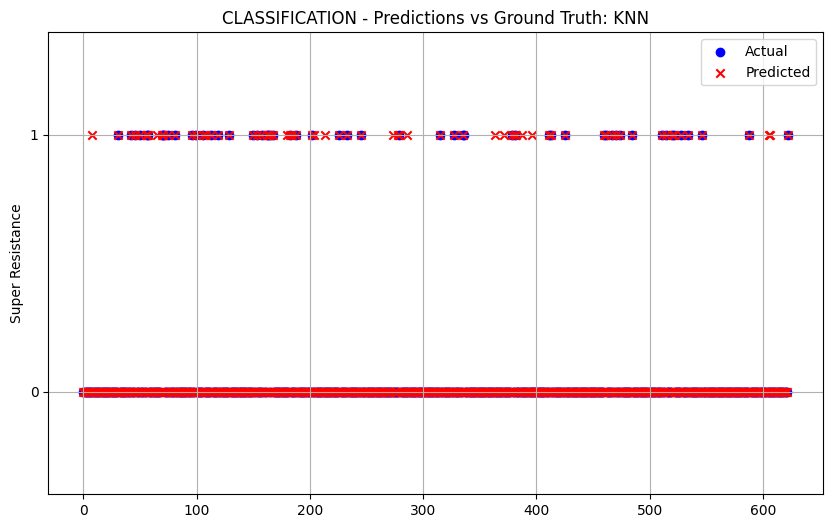

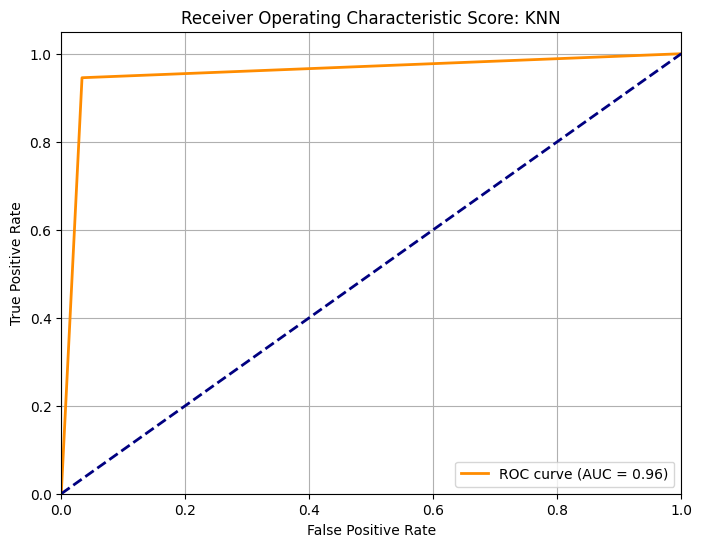

{'Accuracy': 0.9646869983948636, 'Precision': 0.9714201181687093, 'Recall': 0.9646869983948636, 'F1 Score': 0.9666768580091213}


In [5]:
from sklearn.neighbors import KNeighborsClassifier

def knn():

    model = KNeighborsClassifier(n_neighbors=5)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred, "KNN"))
    
knn()


# 2. Naive Bayes

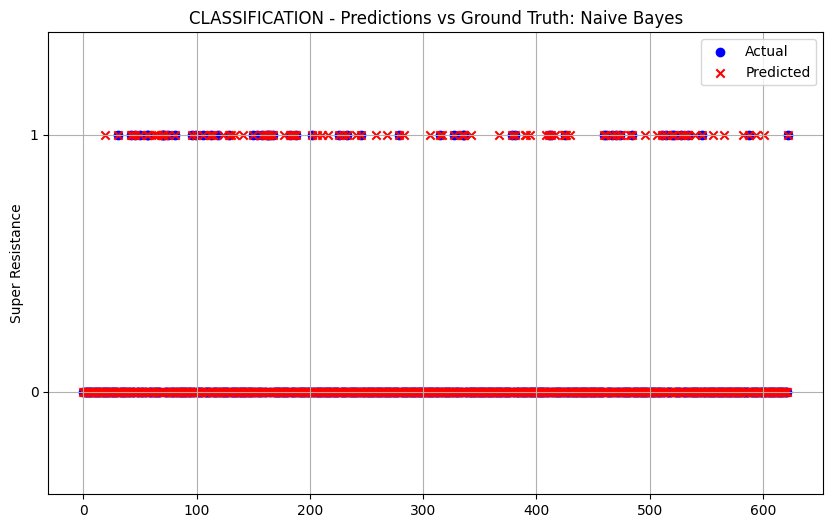

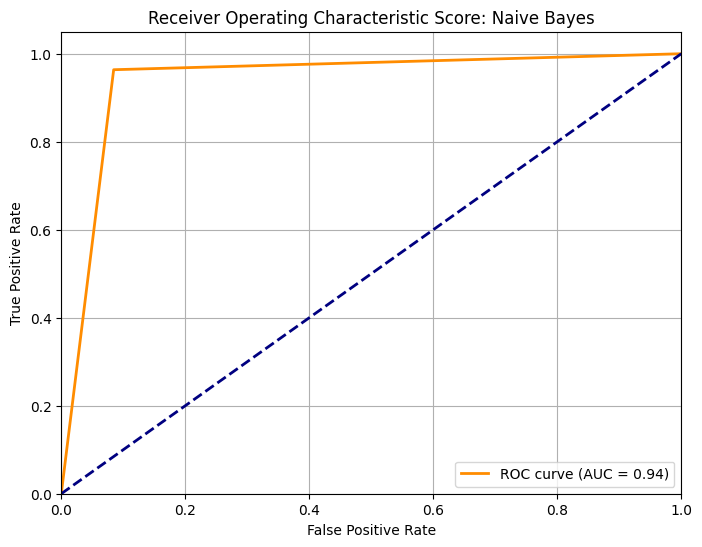

{'Accuracy': 0.9197431781701445, 'Precision': 0.9545507880062374, 'Recall': 0.9197431781701445, 'F1 Score': 0.9298824221512605}


In [6]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes():
   
    model = GaussianNB()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print (eval_classification(y_test, y_pred, 'Naive Bayes'))

naive_bayes()

# 3. Logistic Regression

Tune with # of iterations

/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


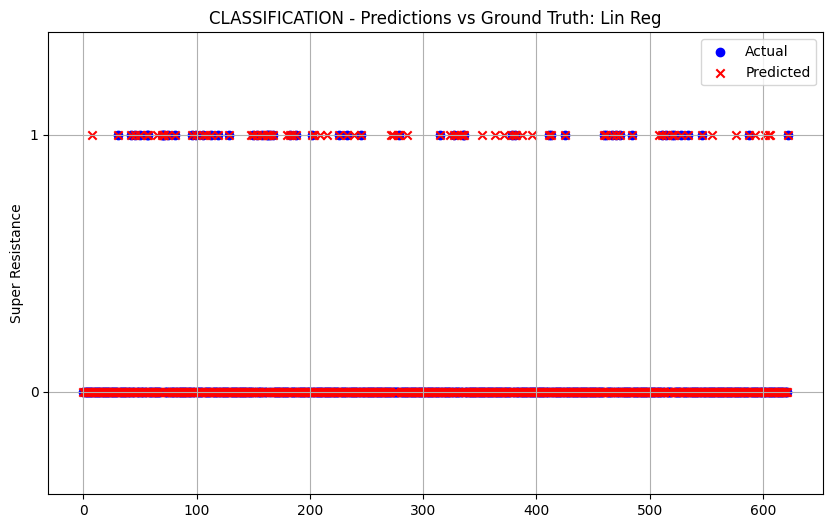

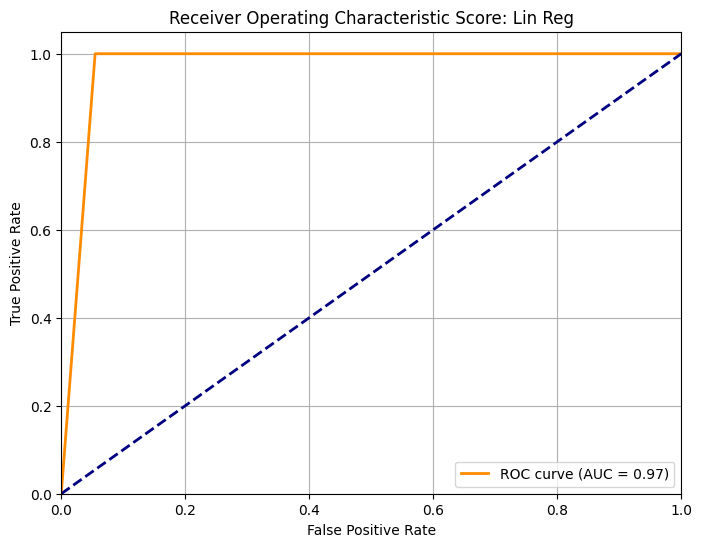

{'Accuracy': 0.9502407704654896, 'Precision': 0.9681772369256038, 'Recall': 0.9502407704654896, 'F1 Score': 0.9550127765481228}


In [7]:
from sklearn.linear_model import LogisticRegression

def logistic_regression():
   
    model = LogisticRegression(max_iter = 10)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred, 'Lin Reg'))

logistic_regression()

# 4. Support Vector Machine

Tune with # of iterations

/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


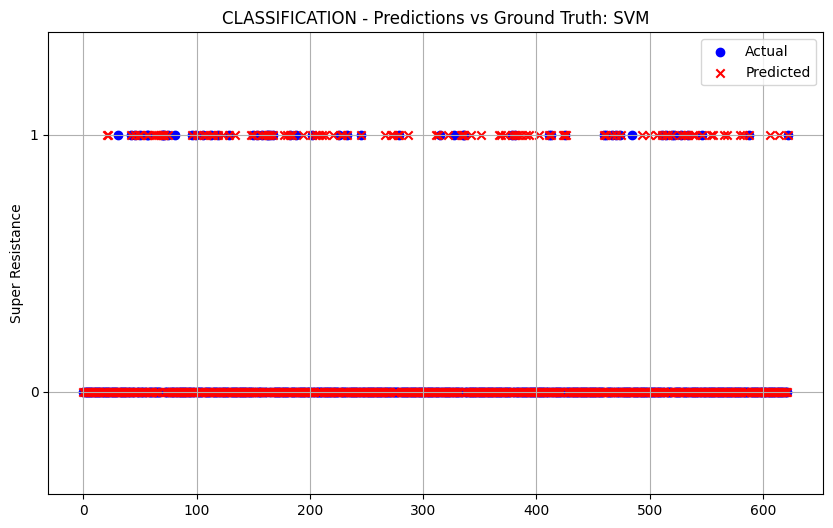

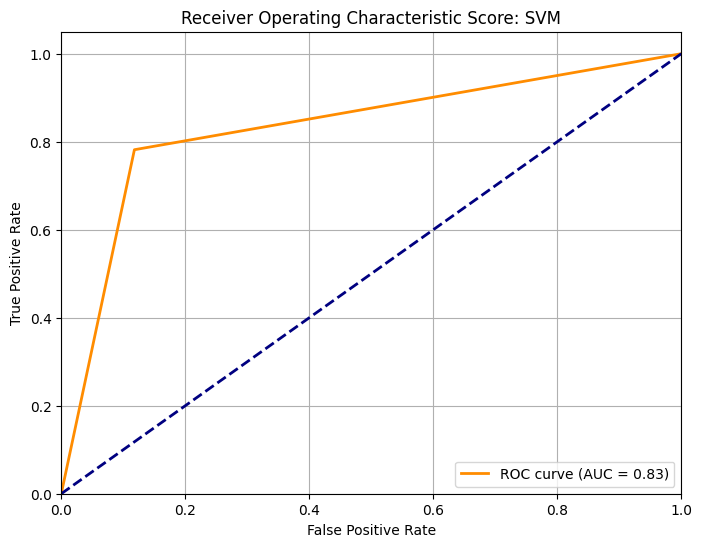

{'Accuracy': 0.8731942215088283, 'Precision': 0.9249012043216656, 'Recall': 0.8731942215088283, 'F1 Score': 0.8911026539938595}


In [8]:
from sklearn.svm import SVC


def svm():
   
    svm_model = SVC(max_iter = 10)

    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)

    print(eval_classification(y_test, y_pred, 'SVM'))

svm()

# 5. Neural Network

Courtesy of Keras

Tune with changing # of hyperparams (architecture, epochs, etc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 128       
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (676.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


2024-10-20 15:33:06.530726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-20 15:33:06.551428: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6d64e51300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-20 15:33:06.551453: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-10-20 15:33:06.554086: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-20 15:33:06.561158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-20 15:33:06.673294: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

78/78 [==============================] - 1s 3ms/step - loss: 0.2552 - accuracy: 0.9064
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9703
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9763
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0472 - accuracy: 0.9787
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9928
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9896
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9904
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9924
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9783
Epoch 10/10
20/20 [==============================] - 0s 787us/step


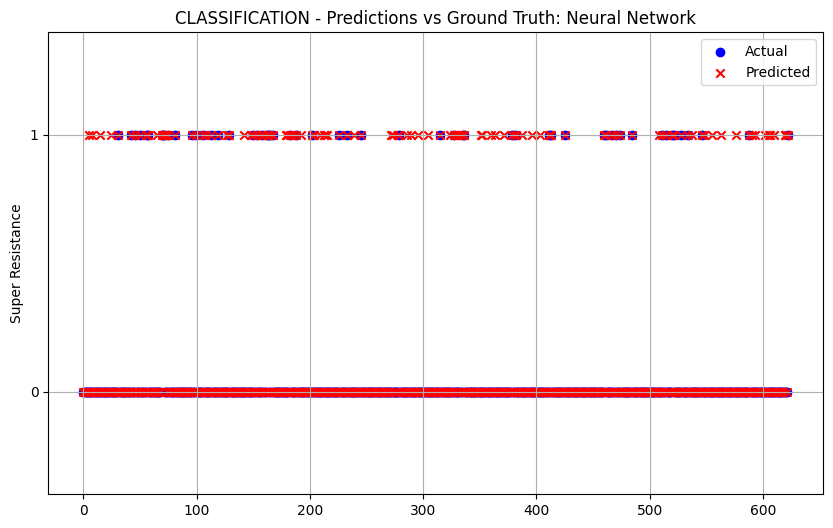

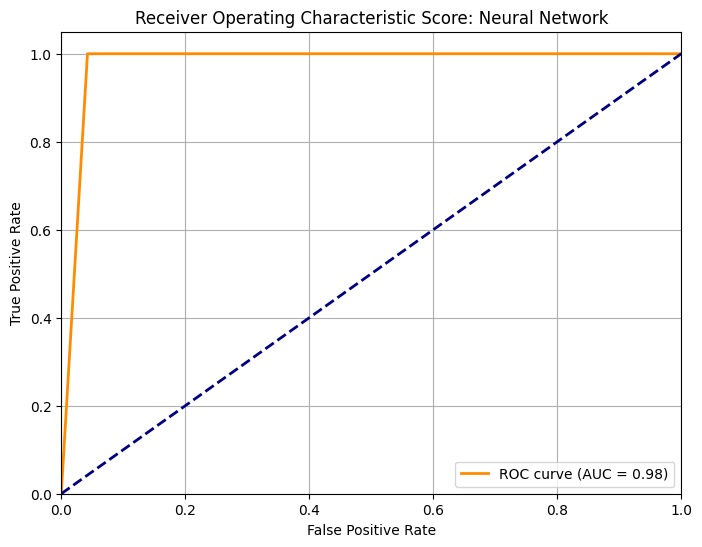

{'Accuracy': 0.9052969502407705, 'Precision': 0.954309932133705, 'Recall': 0.9052969502407705, 'F1 Score': 0.9192339541407705}


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


def build_architecture(input_shape):
  
    model = Sequential()
    
    model.add(Dense(8, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) #Sigmoid activation for binary classification. Simple task so no need for the whole linear-last + manual sigmoid for numeric integrity.
    
    model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def neural_network():
    epochs = 10
    
    columns = X_train.shape[1]
    model = build_architecture(columns)

    print(model.summary())

    model.fit(X_train, y_train, epochs=epochs, batch_size=32)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred, 'Neural Network'))

neural_network()

# 6. Extreme Gradient Boosting with xgboost


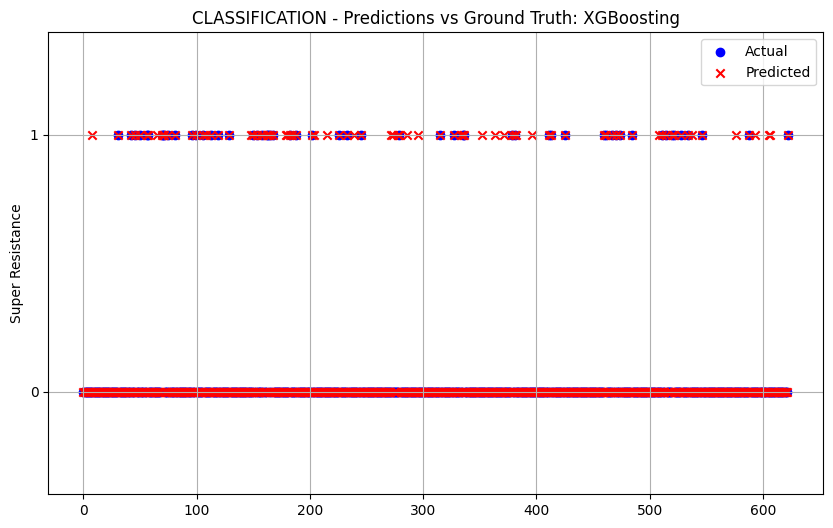

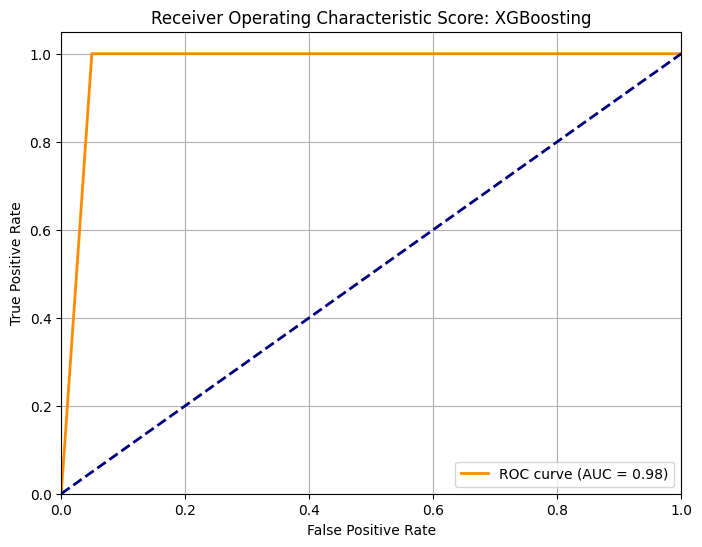

{'Accuracy': 0.9550561797752809, 'Precision': 0.9702179504534993, 'Recall': 0.9550561797752809, 'F1 Score': 0.9590478155640875}


In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

xgb_model = xgb.XGBRegressor(objective='binary:logistic', n_estimators=100,  max_depth=3, learning_rate=0.01)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(eval_classification(y_test, y_pred, 'XGBoosting'))

# 7. Random Forest Classifier


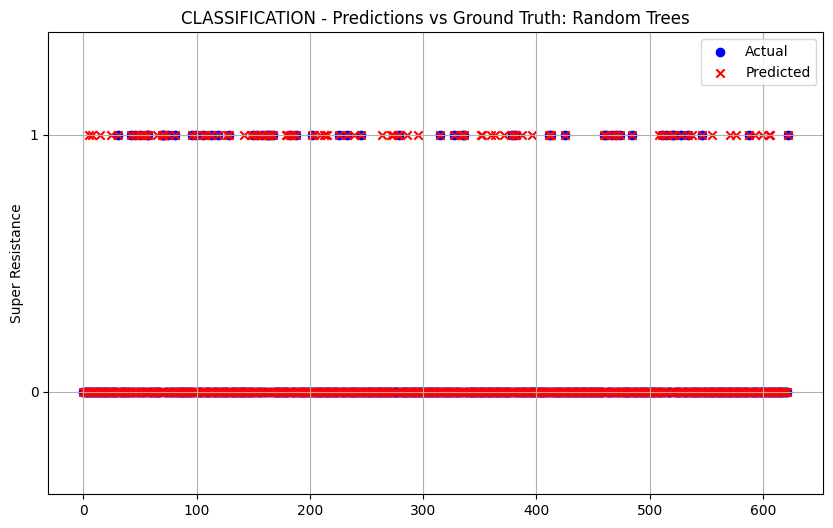

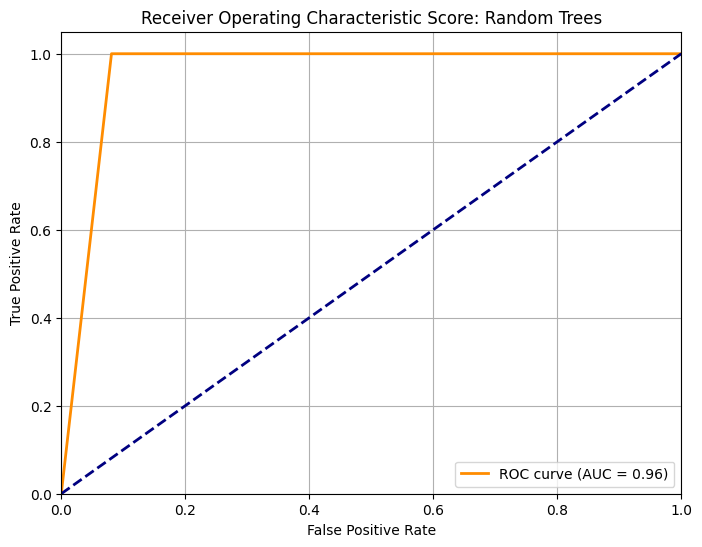

{'Accuracy': 0.9261637239165329, 'Precision': 0.9597921268852407, 'Recall': 0.9261637239165329, 'F1 Score': 0.9354918283791596}


In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(eval_classification(y_test, y_pred, 'Random Trees'))